#### My own functions

In [0]:
def plot_hist(df, col, label):
    plt.hist(df[col], label = label)
    plt.legend()
    plt.show()

### 1. Data Preparation

In [0]:
# General imports
import numpy as np
np.random.seed(0)
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import os, sys, gc, warnings, random, datetime
from sklearn import metrics
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import math

warnings.filterwarnings('ignore')

In [0]:
########################### Helpers
#################################################################################
## -------------------
## Seeder
# :seed to make all processes deterministic     # type: int
def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
## ------------------- 

## -------------------
## Memory Reducer
# :df pandas dataframe to reduce size             # type: pd.DataFrame()
# :verbose                                        # type: bool
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df
## -------------------

In [0]:
########################### Vars
#################################################################################
SEED = 42
seed_everything(SEED)
LOCAL_TEST = False
TARGET = 'isFraud'

In [5]:
########################### DATA LOAD
#################################################################################
print('Load Data')

train_df = pd.read_csv('/content/train_transaction.csv')
test_df = pd.read_csv('/content/test_transaction.csv')
test_df['isFraud'] = 0

train_identity = pd.read_csv('/content/train_identity.csv')
test_identity = pd.read_csv('/content/test_identity.csv')

Load Data


In [0]:
########################### Base check
#################################################################################

if LOCAL_TEST:
    for df2 in [train_df, test_df, train_identity, test_identity]:
        df = reduce_mem_usage(df2)

        for col in list(df):
            if not df[col].equals(df2[col]):
                print('Bad transformation', col)

In [7]:
########################### Base Minification
#################################################################################

train_df = reduce_mem_usage(train_df)
test_df  = reduce_mem_usage(test_df)

train_identity = reduce_mem_usage(train_identity)
test_identity  = reduce_mem_usage(test_identity)

Mem. usage decreased to 111.83 Mb (70.8% reduction)
Mem. usage decreased to 109.22 Mb (72.2% reduction)
Mem. usage decreased to 25.86 Mb (42.7% reduction)
Mem. usage decreased to 25.44 Mb (42.7% reduction)


In [0]:
base_columns = list(train_df) + list(train_identity)

In [0]:
########################### Columns
#################################################################################
## Main Data
# 'TransactionID',
# 'isFraud',
# 'TransactionDT',
# 'TransactionAmt',
# 'ProductCD',
# 'card1' - 'card6',
# 'addr1' - 'addr2',
# 'dist1' - 'dist2',
# 'P_emaildomain' - 'R_emaildomain',
# 'C1' - 'C14'
# 'D1' - 'D15'
# 'M1' - 'M9'
# 'V1' - 'V339'

## Identity Data
# 'TransactionID'
# 'id_01' - 'id_38'
# 'DeviceType',
# 'DeviceInfo'

### 2. Data Preprocessing

**Dataset Columns**

**Transaction Data**

'TransactionID'

'isFraud'

'TransactionDT'

'TransactionAmt'

'ProductCD' **Categorical Features**

'card1' - 'card6' **Categorical Features**

'addr1' - 'addr2' **Categorical Features**

'dist1' - 'dist2'

'P_emaildomain' **Categorical Features**

'R_emaildomain' **Categorical Features**

'C1' - 'C14'

'D1' - 'D15'

'M1' - 'M9' **Categorical Features**

'V1' - 'V339'




**Identity Data**

'TransactionID'

'id_01' - 'id_38' **Categorical Features id_12 - id_38**

'DeviceType' **Categorical Features**

'DeviceInfo' **Categorical Features**

#### 2.1 Product CD

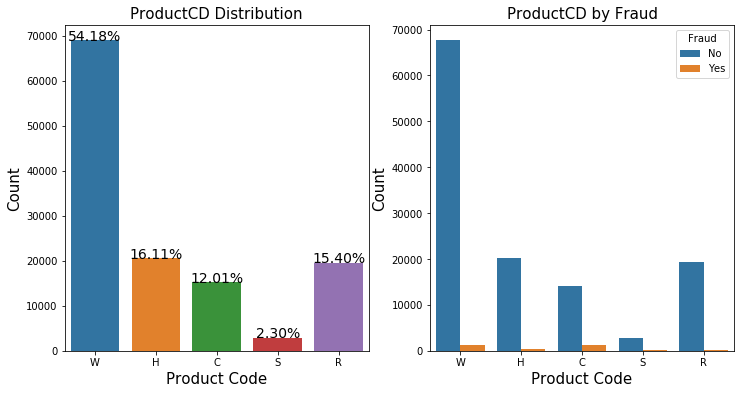

In [10]:
plt.figure(figsize=(12,6))

total = len(train_df)

plt.subplot(121)
g = sns.countplot(x = 'ProductCD', data = train_df)
g.set_title('ProductCD Distribution', fontsize = 15)
g.set_xlabel("Product Code", fontsize=15)
g.set_ylabel("Count", fontsize=15)
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=14) 

plt.subplot(122)
g1 = sns.countplot(x='ProductCD', hue='isFraud', data=train_df)
g1.set_title('ProductCD by Fraud', fontsize = 15)
g1.set_xlabel("Product Code", fontsize=15)
g1.set_ylabel("Count", fontsize=15)
plt.legend(title='Fraud', loc='best', labels=['No', 'Yes'])

In [11]:
train_df[train_df['isFraud'] == 1]['ProductCD'].value_counts(normalize = True)

W    0.411915
C    0.390252
H    0.115005
R    0.060529
S    0.022300
Name: ProductCD, dtype: float64

(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

<Figure size 864x864 with 0 Axes>

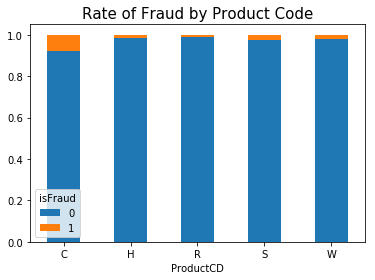

In [12]:
plt.figure(figsize = (12,12))
temp = train_df.groupby('ProductCD')['isFraud'].value_counts(normalize = True).unstack()
a = temp.plot.bar(stacked = True)
a.set_title('Rate of Fraud by Product Code', fontsize = 15)
plt.xticks(rotation = 'horizontal')

These results susgest that with product code, we need to do 2 things:
* Encode categorical levels using Frequency Encoding
* Add target mean by categorical level. It is found here that product C has highest fraud rate, compared to others

In [0]:
# ProductCD Frequency Encoding
col = 'ProductCD'
temp_df = pd.concat([train_df[[col]], test_df[[col]]])   # I don't want to use test data
#temp_df = train_df[[col]]
col_encoded = temp_df[col].value_counts().to_dict()
train_df[col] = train_df[col].map(col_encoded)
test_df[col]  = test_df[col].map(col_encoded)

In [14]:
## ProductCD Target mean
for col in ['ProductCD']:
    temp_dict = train_df.groupby([col])[TARGET].agg(['mean']).reset_index().rename(
                                                        columns={'mean': col+'_target_mean'})
    print(temp_dict)
    print('=============')
    
    temp_dict.index = temp_dict[col].values
    print(temp_dict.index)
    print('=============')
    
    temp_dict = temp_dict[col+'_target_mean'].to_dict()
    print(temp_dict)
    print('****************')
    
    train_df[col+'_target_mean'] = train_df[col].map(temp_dict)
    test_df[col+'_target_mean']  = test_df[col].map(temp_dict)

   ProductCD  ProductCD_target_mean
0       5693               0.023874
1      23543               0.017600
2      25663               0.009693
3      27914               0.080139
4     175085               0.018743
Int64Index([5693, 23543, 25663, 27914, 175085], dtype='int64')
{5693: 0.023874488403819918, 23543: 0.01760031202769246, 25663: 0.009693382990663742, 27914: 0.08013868899646735, 175085: 0.01874320504457491}
****************


In [15]:
train_df[['ProductCD', 'ProductCD_target_mean']].head()

,ProductCD,ProductCD_target_mean
0,175085,0.018743
1,175085,0.018743
2,175085,0.018743
3,175085,0.018743
4,23543,0.017600


### 2.2 Card1 - Card6

#### a. Card 1, 2, 3, 5

The card 1,2,3, and 5 was represented as numerical values, temping us to plot the histogram. However, we need to remember that card columns were classified as categorical variables. Meaning it's likely that these numerical variables were coded for categorical variables.

In [16]:
train_df.describe().loc[:,'card1':'card5']

,card1,card2,card3,card5
count,127315.000000,125636.0,127312.0,126622.0
mean,9885.352629,NaN,NaN,NaN
std,4937.225735,NaN,0.0,0.0
min,1001.000000,100.0,100.0,100.0
25%,6019.000000,219.0,150.0,166.0
50%,9715.000000,390.0,150.0,226.0
75%,14290.000000,514.0,150.0,226.0
max,18396.000000,600.0,229.0,237.0


In [17]:
train_df.loc[:,'card1':'card5'].nunique()

card1    8490
card2     499
card3      80
card4       4
card5      90
dtype: int64

Card 1 contains 13553 unique values, suggesting card 1 may have been ID of the card. Card 2,3 and 5 have less unique values, so perhaps they could be expiration date, or combinations that generate card identity? Since we don't know how these information was scrammbled, we might pickup patterns generated by encryption algorithm instead of data. We can calculate target mean grouped by 'card1' - 'card5' (except 'card4'

In [0]:
#for col in ['card1', 'card2', 'card3', 'card5']:
#    temp_dict = train_df.groupby([col])[TARGET].agg(['mean']).reset_index().rename(
#                                                        columns={'mean': col+'_target_mean'})
#    temp_dict.index = temp_dict[col].values
#    temp_dict = temp_dict[col+'_target_mean'].to_dict()

#    train_df[col+'_target_mean'] = train_df[col].map(temp_dict)
#    test_df[col+'_target_mean']  = test_df[col].map(temp_dict)

In [0]:
########################### Reset values for "noise" card1
i_cols = ['card1']

for col in i_cols: 
    valid_card = pd.concat([train_df[[col]], test_df[[col]]])
    valid_card = valid_card[col].value_counts()
    valid_card = valid_card[valid_card>2]
    valid_card = list(valid_card.index)

    train_df[col] = np.where(train_df[col].isin(test_df[col]), train_df[col], np.nan)
    test_df[col]  = np.where(test_df[col].isin(train_df[col]), test_df[col], np.nan)

    train_df[col] = np.where(train_df[col].isin(valid_card), train_df[col], np.nan)
    test_df[col]  = np.where(test_df[col].isin(valid_card), test_df[col], np.nan)

b. Card4

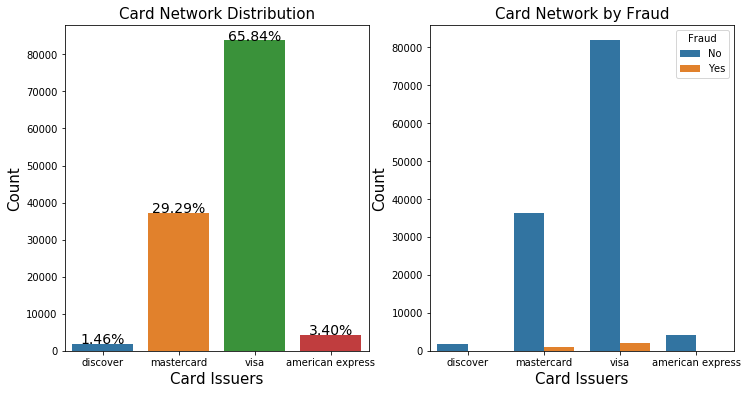

In [20]:
plt.figure(figsize=(12,6))

total = len(train_df)

plt.subplot(121)
g = sns.countplot(x = 'card4', data = train_df)
g.set_title('Card Network Distribution', fontsize = 15)
g.set_xlabel("Card Issuers", fontsize=15)
g.set_ylabel("Count", fontsize=15)
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=14) 

plt.subplot(122)
g1 = sns.countplot(x='card4', hue='isFraud', data=train_df)
g1.set_title('Card Network by Fraud', fontsize = 15)
g1.set_xlabel("Card Issuers", fontsize=15)
g1.set_ylabel("Count", fontsize=15)
plt.legend(title='Fraud', loc='best', labels=['No', 'Yes'])

(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

<Figure size 864x864 with 0 Axes>

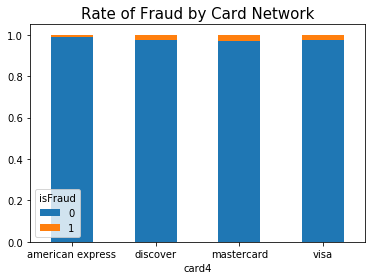

In [21]:
# visualization of table
plt.figure(figsize=(12,12))
b = train_df.groupby('card4')['isFraud'].value_counts(normalize = True).unstack().plot.bar(stacked = True)
b.set_title('Rate of Fraud by Card Network', fontsize = 15)
plt.xticks(rotation='horizontal')

In [0]:
# Card4 Frequency Encoding
col = 'card4'
temp_df = pd.concat([train_df[[col]], test_df[[col]]])   # I don't want to use test data
#temp_df = train_df[[col]]
col_encoded = temp_df[col].value_counts().to_dict()
train_df[col] = train_df[col].map(col_encoded)
test_df[col]  = test_df[col].map(col_encoded)

## Card4 Target mean
#for col in ['card4']:
#    temp_dict = train_df.groupby([col])[TARGET].agg(['mean']).reset_index().rename(
#                                                        columns={'mean': col+'_target_mean'})
#    temp_dict.index = temp_dict[col].values
#    temp_dict = temp_dict[col+'_target_mean'].to_dict()

#    train_df[col+'_target_mean'] = train_df[col].map(temp_dict)
#    test_df[col+'_target_mean']  = test_df[col].map(temp_dict)

c. Card6

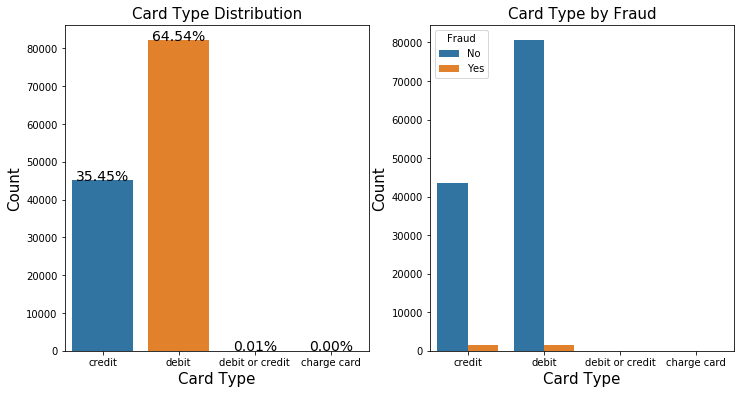

In [23]:
plt.figure(figsize=(12,6))

total = len(train_df)

plt.subplot(121)
g = sns.countplot(x = 'card6', data = train_df)
g.set_title('Card Type Distribution', fontsize = 15)
g.set_xlabel("Card Type", fontsize=15)
g.set_ylabel("Count", fontsize=15)
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=14) 

plt.subplot(122)
g1 = sns.countplot(x='card6', hue='isFraud', data=train_df)
g1.set_title('Card Type by Fraud', fontsize = 15)
g1.set_xlabel("Card Type", fontsize=15)
g1.set_ylabel("Count", fontsize=15)
plt.legend(title='Fraud', loc='best', labels=['No', 'Yes'])

(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

<Figure size 864x864 with 0 Axes>

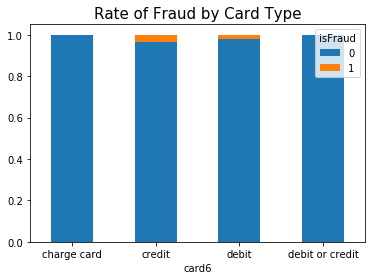

In [24]:
# visualization of table
plt.figure(figsize=(12,12))
c = train_df.groupby('card6')['isFraud'].value_counts(normalize = True).unstack().plot.bar(stacked = True)
c.set_title('Rate of Fraud by Card Type', fontsize = 15)
plt.xticks(rotation='horizontal')

Credit card has much higher fraud rate as compared with other types of card

In [0]:
# Card6 Frequency Encoding
col = 'card6'
temp_df = pd.concat([train_df[[col]], test_df[[col]]])   # I don't want to use test data
#temp_df = train_df[[col]]
col_encoded = temp_df[col].value_counts().to_dict()
train_df[col] = train_df[col].map(col_encoded)
test_df[col]  = test_df[col].map(col_encoded)

## Card6 Target mean
#for col in ['card6']:
#    temp_dict = train_df.groupby([col])[TARGET].agg(['mean']).reset_index().rename(
#                                                        columns={'mean': col+'_target_mean'})
#    temp_dict.index = temp_dict[col].values
#    temp_dict = temp_dict[col+'_target_mean'].to_dict()

#    train_df[col+'_target_mean'] = train_df[col].map(temp_dict)
#    test_df[col+'_target_mean']  = test_df[col].map(temp_dict)

### 2.3 Addr1 - Addr2

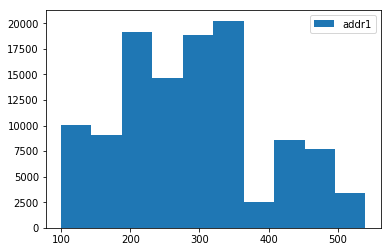

In [26]:
plot_hist(train_df, 'addr1', 'addr1')

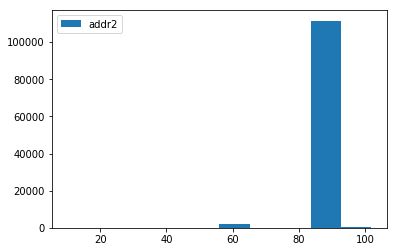

In [27]:
plot_hist(train_df, 'addr2', 'addr2')

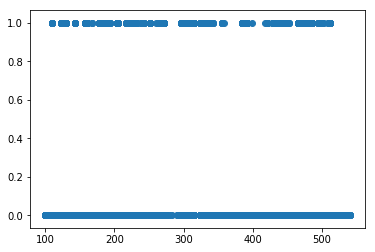

In [28]:
plt.scatter(x='addr1', y ='isFraud', data = train_df)
plt.show()

In [0]:
## Addr1 - Addr2 Target mean
#for col in ['addr1', 'addr2']:
#    temp_dict = train_df.groupby([col])[TARGET].agg(['mean']).reset_index().rename(
#                                                        columns={'mean': col+'_target_mean'})
#    temp_dict.index = temp_dict[col].values
#    temp_dict = temp_dict[col+'_target_mean'].to_dict()

#    train_df[col+'_target_mean'] = train_df[col].map(temp_dict)
#    test_df[col+'_target_mean']  = test_df[col].map(temp_dict)

### 2.4 Email domain

In [0]:
#train_df["P_parent_emaildomain"] = train_df["P_emaildomain"].str.split('.', expand = True)[[0]]
#train_df["R_parent_emaildomain"] = train_df["R_emaildomain"].str.split('.', expand = True)[[0]]

#test_df["P_parent_emaildomain"] = test_df["P_emaildomain"].str.split('.', expand = True)[[0]]
#test_df["R_parent_emaildomain"] = test_df["R_emaildomain"].str.split('.', expand = True)[[0]]

In [0]:
# P-emaildomain & R-emaildomain Frequency Encoding
#for col in ['P_parent_emaildomain', 'R_parent_emaildomain']:
#    temp_df = pd.concat([train_df[[col]], test_df[[col]]])   # I don't want to use test data
    #temp_df = train_df[[col]]
#    col_encoded = temp_df[col].value_counts().to_dict()
#    train_df[col] = train_df[col].map(col_encoded)
#    test_df[col]  = test_df[col].map(col_encoded)

## P-emaildomain & R-emaildomain Target mean
#for col in ['P_parent_emaildomain', 'R_parent_emaildomain']:
#    temp_dict = train_df.groupby([col])[TARGET].agg(['mean']).reset_index().rename(
#                                                        columns={'mean': col+'_target_mean'})
#    temp_dict.index = temp_dict[col].values
#    temp_dict = temp_dict[col+'_target_mean'].to_dict()

#    train_df[col+'_target_mean'] = train_df[col].map(temp_dict)
#    test_df[col+'_target_mean']  = test_df[col].map(temp_dict)

### 2.5 'M1' - 'M9'

In [32]:
#temp = train_df[train_df['isFraud']==True].groupby('M4')['isFraud'].value_counts(normalize=True)
temp = train_df.groupby('M4')['isFraud'].value_counts(normalize = True)
temp

M4  isFraud
M0  0          0.963823
    1          0.036177
M1  0          0.978788
    1          0.021212
M2  0          0.921042
    1          0.078958
Name: isFraud, dtype: float64

In [33]:
train_df['M4'].head()

0     M2
1     M0
2     M0
3     M0
4    NaN
Name: M4, dtype: object

In [0]:
# 'M4' Target mean
for col in ['M4']:
    temp_dict = train_df.groupby([col])[TARGET].agg(['mean']).reset_index().rename(
                                                        columns={'mean': col+'_target_mean'})
    temp_dict.index = temp_dict[col].values
    temp_dict = temp_dict[col+'_target_mean'].to_dict()

    train_df[col+'_target_mean'] = train_df[col].map(temp_dict)
    test_df[col+'_target_mean']  = test_df[col].map(temp_dict)

In [35]:
for col in ['M1','M2','M3','M5','M6','M7','M8','M9']:
    train_df[col] = train_df[col].map({'T':1, 'F':0})
    test_df[col]  = test_df[col].map({'T':1, 'F':0})
    
for col in ['M4']:
    print('Encoding', col)
    temp_df = pd.concat([train_df[[col]], test_df[[col]]])
    col_encoded = temp_df[col].value_counts().to_dict()   
    train_df[col] = train_df[col].map(col_encoded)
    test_df[col]  = test_df[col].map(col_encoded)
    print(col_encoded)

Encoding M4
{'M0': 78393, 'M2': 24709, 'M1': 21316}


In [0]:
# let's combine the data and work with the whole dataset

#train = pd.merge(train_df, train_identity, on='TransactionID', how='left')
#test = pd.merge(test_df, test_identity, on='TransactionID', how='left')
#del train_identity, train_df, test_identity, test_df


In [0]:
## Reduce Memory Usage

#train = reduce_mem_usage(train)
#test = reduce_mem_usage(test)

### 2.6 'id_12' - 'id_38'

In [0]:
#train['id_23'].value_counts()

In [0]:
# Calculate Target Mean grouped by 'id_23'
## 'id_23' Target mean
#for col in ['id_23']:
#    temp_dict = train.groupby([col])[TARGET].agg(['mean']).reset_index().rename(
#                                                        columns={'mean': col+'_target_mean'})
#    temp_dict.index = temp_dict[col].values
#    temp_dict = temp_dict[col+'_target_mean'].to_dict()

#    train[col] = train[col].map(temp_dict)
#    test[col]  = test[col].map(temp_dict)

In [0]:
########################### Identity columns
#################################################################################

def minify_identity_df(df):

    df['id_12'] = df['id_12'].map({'Found':1, 'NotFound':0})
    df['id_15'] = df['id_15'].map({'New':2, 'Found':1, 'Unknown':0})
    df['id_16'] = df['id_16'].map({'Found':1, 'NotFound':0})

    df['id_23'] = df['id_23'].map({'TRANSPARENT':4, 'IP_PROXY':3, 'IP_PROXY:ANONYMOUS':2, 'IP_PROXY:HIDDEN':1})

    df['id_27'] = df['id_27'].map({'Found':1, 'NotFound':0})
    df['id_28'] = df['id_28'].map({'New':2, 'Found':1})

    df['id_29'] = df['id_29'].map({'Found':1, 'NotFound':0})

    df['id_35'] = df['id_35'].map({'T':1, 'F':0})
    df['id_36'] = df['id_36'].map({'T':1, 'F':0})
    df['id_37'] = df['id_37'].map({'T':1, 'F':0})
    df['id_38'] = df['id_38'].map({'T':1, 'F':0})

    df['id_34'] = df['id_34'].fillna(':0')
    df['id_34'] = df['id_34'].apply(lambda x: x.split(':')[1]).astype(np.int8)
    df['id_34'] = np.where(df['id_34']==0, np.nan, df['id_34'])
    
    df['id_33'] = df['id_33'].fillna('0x0')
    df['id_33_0'] = df['id_33'].apply(lambda x: x.split('x')[0]).astype(int)
    df['id_33_1'] = df['id_33'].apply(lambda x: x.split('x')[1]).astype(int)
    df['id_33'] = np.where(df['id_33']=='0x0', np.nan, df['id_33'])

    df['DeviceType'].map({'desktop':1, 'mobile':0})
    return df

train_identity = minify_identity_df(train_identity)
test_identity = minify_identity_df(test_identity)

for col in ['id_33']:
    train_identity[col] = train_identity[col].fillna('unseen_before_label')
    test_identity[col]  = test_identity[col].fillna('unseen_before_label')
    
    le = LabelEncoder()
    le.fit(list(train_identity[col])+list(test_identity[col]))
    train_identity[col] = le.transform(train_identity[col])
    test_identity[col]  = le.transform(test_identity[col])

### 3. Feature Engineering

#### 3.1 TransactionDT

In [0]:
START_DATE = datetime.datetime.strptime('2018-01-01', '%Y-%m-%d')

for df in [train_df, test_df]:
    # Temporary
    df['DT'] = df['TransactionDT'].apply(lambda x: START_DATE + (datetime.timedelta(seconds = x)))
    df['DT_M'] = df['DT'].dt.month
    df['DT_W'] = df['DT'].dt.weekofyear
    df['DT_D'] = df['DT'].dt.dayofyear
    
    df['DT_hour'] = df['DT'].dt.hour
    df['DT_day_week'] = df['DT'].dt.dayofweek
    df['DT_day'] = df['DT'].dt.day
    
    # D9 column
    df['D9'] = np.where(df['D9'].isna(),0,1)

#del train_df['DT']
#del test_df['DT']

#### 3.2 Transaction Amount

In [0]:
train_df['TransactionAmt_to_mean_ProductCD'] = train_df['TransactionAmt'] / train_df.groupby(['ProductCD'])['TransactionAmt'].transform('mean')
train_df['TransactionAmt_to_mean_Hour'] = train_df['TransactionAmt'] / train_df.groupby(['DT_hour'])['TransactionAmt'].transform('mean')
train_df['TransactionAmt_to_std_ProductCD'] = train_df['TransactionAmt'] / train_df.groupby(['ProductCD'])['TransactionAmt'].transform('std')
train_df['TransactionAmt_to_std_Hour'] = train_df['TransactionAmt'] / train_df.groupby(['DT_hour'])['TransactionAmt'].transform('std')

test_df['TransactionAmt_to_mean_ProductCD'] = test_df['TransactionAmt'] / train_df.groupby(['ProductCD'])['TransactionAmt'].transform('mean')
test_df['TransactionAmt_to_mean_Hour'] = test_df['TransactionAmt'] / train_df.groupby(['DT_hour'])['TransactionAmt'].transform('mean')
test_df['TransactionAmt_to_std_ProductCD'] = test_df['TransactionAmt'] / train_df.groupby(['ProductCD'])['TransactionAmt'].transform('std')
test_df['TransactionAmt_to_std_Hour'] = test_df['TransactionAmt'] / train_df.groupby(['DT_hour'])['TransactionAmt'].transform('std')

In [0]:
# Let's add some kind of client uID based on cardID ad addr columns
# The value will be very specific for each client so we need to remove it
# from final feature. But we can use it for aggregations.
train_df['uid'] = train_df['card1'].astype(str)+'_'+train_df['card2'].astype(str)
test_df['uid'] = test_df['card1'].astype(str)+'_'+test_df['card2'].astype(str)

train_df['uid2'] = train_df['uid'].astype(str)+'_'+train_df['card3'].astype(str)+'_'+train_df['card4'].astype(str)
test_df['uid2'] = test_df['uid'].astype(str)+'_'+test_df['card3'].astype(str)+'_'+test_df['card4'].astype(str)

train_df['uid3'] = train_df['uid2'].astype(str)+'_'+train_df['addr1'].astype(str)+'_'+train_df['addr2'].astype(str)
test_df['uid3'] = test_df['uid2'].astype(str)+'_'+test_df['addr1'].astype(str)+'_'+test_df['addr2'].astype(str)

# Check if the Transaction Amount is common or not (we can use freq encoding here)
# In our dialog with a model we are telling to trust or not to these values   
train_df['TransactionAmt_check'] = np.where(train_df['TransactionAmt'].isin(test_df['TransactionAmt']), 1, 0)
test_df['TransactionAmt_check']  = np.where(test_df['TransactionAmt'].isin(train_df['TransactionAmt']), 1, 0)

#
i_cols = ['card1','card2','card3','card5','uid','uid2','uid3']

for col in i_cols:
    for agg_type in ['mean','std']:
        new_col_name = col+'_TransactionAmt_'+agg_type
        temp_df = pd.concat([train_df[[col, 'TransactionAmt']], test_df[[col,'TransactionAmt']]])
        #temp_df['TransactionAmt'] = temp_df['TransactionAmt'].astype(int)
        temp_df = temp_df.groupby([col])['TransactionAmt'].agg([agg_type]).reset_index().rename(
                                                columns={agg_type: new_col_name})
        
        temp_df.index = list(temp_df[col])
        temp_df = temp_df[new_col_name].to_dict()   
    
        train_df[new_col_name] = train_df[col].map(temp_df)
        test_df[new_col_name]  = test_df[col].map(temp_df)

In [0]:
train_df['TransactionAmt'] = np.log1p(train_df['TransactionAmt'])
test_df['TransactionAmt'] = np.log1p(test_df['TransactionAmt'])      

In [0]:
# 'P_emaildomain' - 'R_emaildomain'
p = 'P_emaildomain'
r = 'R_emaildomain'
uknown = 'email_not_provided'

for df in [train_df, test_df]:
    df[p] = df[p].fillna(uknown)
    df[r] = df[r].fillna(uknown)
    
    # Check if P_emaildomain matches R_emaildomain
    df['email_check'] = np.where((df[p]==df[r])&(df[p]!=uknown),1,0)

    df[p+'_prefix'] = df[p].apply(lambda x: x.split('.')[0])
    df[r+'_prefix'] = df[r].apply(lambda x: x.split('.')[0])

## Local test doesn't show any boost here, 
## but I think it's a good option for model stability 

## Also, we will do frequency encoding later

In [0]:
########################### Device info
for df in [train_identity, test_identity]:
    ########################### Device info
    df['DeviceInfo'] = df['DeviceInfo'].fillna('unknown_device').str.lower()
    df['DeviceInfo_device'] = df['DeviceInfo'].apply(lambda x: ''.join([i for i in x if i.isalpha()]))
    df['DeviceInfo_version'] = df['DeviceInfo'].apply(lambda x: ''.join([i for i in x if i.isnumeric()]))
    
    ########################### Device info 2
    df['id_30'] = df['id_30'].fillna('unknown_device').str.lower()
    df['id_30_device'] = df['id_30'].apply(lambda x: ''.join([i for i in x if i.isalpha()]))
    df['id_30_version'] = df['id_30'].apply(lambda x: ''.join([i for i in x if i.isnumeric()]))
    
    ########################### Browser
    df['id_31'] = df['id_31'].fillna('unknown_device').str.lower()
    df['id_31_device'] = df['id_31'].apply(lambda x: ''.join([i for i in x if i.isalpha()]))

In [0]:
########################### Merge Identity columns
temp_df = train_df[['TransactionID']]
temp_df = temp_df.merge(train_identity, on=['TransactionID'], how='left')
del temp_df['TransactionID']
train_df = pd.concat([train_df,temp_df], axis=1)
    
temp_df = test_df[['TransactionID']]
temp_df = temp_df.merge(test_identity, on=['TransactionID'], how='left')
del temp_df['TransactionID']
test_df = pd.concat([test_df,temp_df], axis=1)

#### 3.3 Frequency Encoding


In [0]:
########################### Freq encoding
i_cols = ['card1','card2','card3','card5',
          'C1','C2','C3','C4','C5','C6','C7','C8','C9','C10','C11','C12','C13','C14',
          'D1','D2','D3','D4','D5','D6','D7','D8',
          'addr1','addr2',
          'dist1','dist2',
          'P_emaildomain', 'R_emaildomain',
          'DeviceInfo','DeviceInfo_device','DeviceInfo_version',
          'id_30','id_30_device','id_30_version',
          'id_31_device',
          'id_33',
          'uid','uid2','uid3',
         ]

for col in i_cols:
    temp_df = pd.concat([train_df[[col]], test_df[[col]]])
    fq_encode = temp_df[col].value_counts(dropna=False).to_dict()   
    train_df[col+'_fq_enc'] = train_df[col].map(fq_encode)
    test_df[col+'_fq_enc']  = test_df[col].map(fq_encode)


for col in ['DT_M','DT_W','DT_D']:
    temp_df = pd.concat([train_df[[col]], test_df[[col]]])
    fq_encode = temp_df[col].value_counts().to_dict()
            
    train_df[col+'_total'] = train_df[col].map(fq_encode)
    test_df[col+'_total']  = test_df[col].map(fq_encode)
        

periods = ['DT_M','DT_W','DT_D']
i_cols = ['uid']
for period in periods:
    for col in i_cols:
        new_column = col + '_' + period
            
        temp_df = pd.concat([train_df[[col,period]], test_df[[col,period]]])
        temp_df[new_column] = temp_df[col].astype(str) + '_' + (temp_df[period]).astype(str)
        fq_encode = temp_df[new_column].value_counts().to_dict()
            
        train_df[new_column] = (train_df[col].astype(str) + '_' + train_df[period].astype(str)).map(fq_encode)
        test_df[new_column]  = (test_df[col].astype(str) + '_' + test_df[period].astype(str)).map(fq_encode)
        
        train_df[new_column] /= train_df[period+'_total']
        test_df[new_column]  /= test_df[period+'_total']

In [0]:
########################### M columns (except M4)
# All these columns are binary encoded 1/0
# We can have some features from it
i_cols = ['M1','M2','M3','M5','M6','M7','M8','M9']

for df in [train_df, test_df]:
    df['M_sum'] = df[i_cols].sum(axis=1).astype(np.int8)
    df['M_na'] = df[i_cols].isna().sum(axis=1).astype(np.int8)

In [49]:
########################### Encode Str columns
# For all such columns (probably not)
# we already did frequency encoding (numeric feature)
# so we will use astype('category') here
for col in list(train_df):
    if train_df[col].dtype=='O':
        print(col)
        train_df[col] = train_df[col].fillna('unseen_before_label')
        test_df[col]  = test_df[col].fillna('unseen_before_label')
        
        train_df[col] = train_df[col].astype(str)
        test_df[col] = test_df[col].astype(str)
        
        le = LabelEncoder()
        le.fit(list(train_df[col])+list(test_df[col]))
        train_df[col] = le.transform(train_df[col])
        test_df[col]  = le.transform(test_df[col])
        
        train_df[col] = train_df[col].astype('category')
        test_df[col] = test_df[col].astype('category')

P_emaildomain
R_emaildomain
uid
uid2
uid3
P_emaildomain_prefix
R_emaildomain_prefix
id_30
id_31
DeviceType
DeviceInfo
DeviceInfo_device
DeviceInfo_version
id_30_device
id_30_version
id_31_device


### 7. Model Running

In [50]:
train_df = reduce_mem_usage(train_df)
test_df = reduce_mem_usage(test_df)
gc.collect()

Mem. usage decreased to 148.92 Mb (28.7% reduction)
Mem. usage decreased to 147.09 Mb (29.5% reduction)


0

In [0]:
for col in list(train_df):
    if train_df[col].dtype == 'O':
        print(col)

In [0]:
## Encode Str columns
for col in list(train_df):
    if train_df[col].dtype=='O':
        print(col)
        train_df[col] = train_df[col].fillna('unseen_before_label')
        test_df[col]  = test_df[col].fillna('unseen_before_label')
        
        train_df[col] = train_df[col].astype(str)
        test_df[col] = test_df[col].astype(str)
        
        le = LabelEncoder()
        le.fit(list(train_df[col])+list(test_df[col]))
        train_df[col] = le.transform(train_df[col])
        test_df[col]  = le.transform(test_df[col])
        print(train_df[col].head())
        
        train_df[col] = train_df[col].astype('category')
        test_df[col] = test_df[col].astype('category')
        print(train_df[col].head())

In [0]:
########################### Model Features 
## We can use set().difference() but the order matters
## Matters only for deterministic results
## In case of remove() we will not change order
## even if variable will be renamed
## please see this link to see how set is ordered
## https://stackoverflow.com/questions/12165200/order-of-unordered-python-sets
rm_cols = [
    'TransactionID','TransactionDT', # These columns are pure noise right now
    TARGET,                          # Not target in features))
    'uid','uid2','uid3',             # Our new client uID -> very noisy data
    'bank_type',                     # Victims bank could differ by time
    'DT','DT_M','DT_W','DT_D',       # Temporary Variables
    'DT_hour','DT_day_week','DT_day',
    'DT_D_total','DT_W_total','DT_M_total',
    'id_30','id_31','id_33',
]

In [54]:
########################### Features elimination 
from scipy.stats import ks_2samp
features_check = []
columns_to_check = set(list(train_df)).difference(base_columns+rm_cols)
for i in columns_to_check:
    features_check.append(ks_2samp(test_df[i], train_df[i])[1])

features_check = pd.Series(features_check, index=columns_to_check).sort_values() 
features_discard = list(features_check[features_check==0].index)
print(features_discard)

# We will reset this list for now,
# Good droping will be in other kernels
# with better checking
features_discard = [] 

# Final features list
features_columns = [col for col in list(train_df) if col not in rm_cols + features_discard]

['id_30_fq_enc', 'C9_fq_enc', 'uid_TransactionAmt_mean', 'card1_TransactionAmt_std', 'C2_fq_enc', 'id_30_version_fq_enc', 'id_33_0', 'id_33_1', 'uid2_TransactionAmt_mean', 'D5_fq_enc', 'card2_TransactionAmt_mean', 'DeviceInfo_device_fq_enc', 'id_30_device', 'uid_DT_D', 'R_emaildomain_prefix', 'DeviceInfo_device', 'C13_fq_enc', 'C10_fq_enc', 'C5_fq_enc', 'TransactionAmt_to_mean_ProductCD', 'D8_fq_enc', 'R_emaildomain_fq_enc', 'D3_fq_enc', 'DeviceInfo_version', 'M4_target_mean', 'C8_fq_enc', 'D2_fq_enc', 'D4_fq_enc', 'C14_fq_enc', 'DeviceInfo_fq_enc', 'email_check', 'id_31_device_fq_enc', 'D1_fq_enc', 'TransactionAmt_to_std_ProductCD', 'C6_fq_enc', 'M_sum', 'id_31_device', 'C4_fq_enc', 'ProductCD_target_mean', 'id_30_device_fq_enc', 'M_na', 'id_30_version', 'card1_TransactionAmt_mean', 'dist1_fq_enc', 'uid_DT_M', 'id_33_fq_enc', 'C12_fq_enc', 'DeviceInfo_version_fq_enc', 'C1_fq_enc']


In [55]:
train_df = reduce_mem_usage(train_df)
test_df  = reduce_mem_usage(test_df)

del train_identity, test_identity
gc.collect()

###########################
x_train_array = np.array(train_df[features_columns])
y_train_array = np.array(train_df[TARGET])#.values

x_train_array = x_train_array.astype('float16')
y_train_array = y_train_array.astype('float16')

for i in range(len(x_train_array)):
    x_train_array[i]=np.nan_to_num(x_train_array[i])
    y_train_array[i]=np.nan_to_num(y_train_array[i]) 
    
# Save 2D numpy array to csv file
#np.savetxt('x_train_array.csv', x_train_array, delimiter=',', fmt='%d')
#np.savetxt('y_train_array.csv', y_train_array, delimiter=',', fmt='%d')

Mem. usage decreased to 148.92 Mb (0.0% reduction)
Mem. usage decreased to 147.09 Mb (0.0% reduction)


In [0]:
tr_x, vl_x, tr_y, vl_y = train_test_split( x_train_array, y_train_array, test_size=0.2, random_state=42, stratify=y_train_array)

### Pytorch

In [0]:
import torch
from torch.autograd import Variable

random.seed(113)
torch.manual_seed(113)
torch.cuda.manual_seed(113)
np.random.seed(113)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


In [58]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [0]:
gpu_use = True

In [0]:
# Wrap in variable
if gpu_use:
    x_train = Variable(torch.from_numpy(tr_x).cuda())   #[:10]))
    y_train = Variable(torch.from_numpy(tr_y).cuda())   #[:10]))
    x_val = Variable(torch.from_numpy(vl_x).cuda())     #[:2]))
    y_val = Variable(torch.from_numpy(vl_y).cuda())     #[:2]))
else:
    x_train = Variable(torch.from_numpy(tr_x))#.cuda())   #[:10]))
    y_train = Variable(torch.from_numpy(tr_y))#.cuda())   #[:10]))
    x_val = Variable(torch.from_numpy(vl_x))#.cuda())     #[:2]))
    y_val = Variable(torch.from_numpy(vl_y))#.cuda())     #[:2]))



In [0]:
class Model_one(torch.nn.Module):

    def __init__(self):
        """
        In the constructor we instantiate two nn.Linear module
        """
        super(Model_one, self).__init__()
# Set 1
#        self.l1 = torch.nn.Linear(507, 512)
#        self.l2 = torch.nn.Linear(512, 256)
#        self.l3 = torch.nn.Linear(256, 128)
#        self.l4 = torch.nn.Linear(128, 64)
#        self.l5 = torch.nn.Linear(64, 32)
#        self.l6 = torch.nn.Linear(32, 1)

# Set 2
        self.l1 = torch.nn.Linear(507, 1024)
        torch.nn.init.xavier_uniform(self.l1.weight)
        self.l1.bias.data.fill_(0.01)
        
        self.l2 = torch.nn.Linear(1024, 512)
        torch.nn.init.xavier_uniform(self.l2.weight)
        self.l2.bias.data.fill_(0.01)

        self.l3 = torch.nn.Linear(512, 256)
        torch.nn.init.xavier_uniform(self.l3.weight)
        self.l3.bias.data.fill_(0.01)

        self.l4 = torch.nn.Linear(256, 128)
        torch.nn.init.xavier_uniform(self.l4.weight)
        self.l4.bias.data.fill_(0.01)

        self.l5 = torch.nn.Linear(128, 64)
        torch.nn.init.xavier_uniform(self.l5.weight)
        self.l5.bias.data.fill_(0.01)

        self.l6 = torch.nn.Linear(64, 1)
        torch.nn.init.xavier_uniform(self.l6.weight)
        self.l6.bias.data.fill_(0.01)



        self.sigmoid = torch.nn.Sigmoid()
        self.relu = torch.nn.ReLU()
        
    def forward(self, x):
        """
        In the forward function we accept a Variable of input data and we must return
        a Variable of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Variables.
        """
        out1 = self.sigmoid(self.l1(x))
        out2 = self.sigmoid(self.l2(out1))
        out3 = self.sigmoid(self.l3(out2))
        out4 = self.sigmoid(self.l4(out3))
        out5 = self.sigmoid(self.l5(out4))
        y_pred = self.sigmoid(self.l6(out5))
        return y_pred
        #     print(out1.data)
        #     print(out2.data)
        #     print(y_pred.data)

In [72]:
# Initiate model
if gpu_use:
    model_one = Model_one()
    model_one.cuda()
else:
    model_one = Model_one()

#del tr_x, tr_y, vl_x, vl_y

# Construct our loss function and an Optimizer. The call to model.parameters()
# in the SGD constructor will contain the learnable parameters of the two
# nn.Linear modules which are members of the model.
criterion = torch.nn.BCELoss(size_average=True)

optimizer = torch.optim.Adam(model_one.parameters(), lr=0.0001)
    
tr_loss = []  
vl_loss = []
ep = []
  
for epoch in range(5000):
    # Forward pass: Compute predicted y by passing x to the model
    y_train_pred = model_one(x_train.float())
    
    
    # Compute loss on training set
    loss_train = criterion(y_train_pred, y_train.float())
    
    
    # Calculate loss on validation set and plot results
    # at certain frequency
    
    if(((epoch + 1)%50 == 0) or (epoch==0)):
    #if(((epoch + 1)%10 == 0) or (epoch==0)):
        y_val_pred = model_one(x_val.float())
        loss_val = criterion(y_val_pred, y_val.float())
    
        print(epoch+1, loss_train.item(), loss_val.item())#.data[0])
        tr_loss.append(loss_train.item())
        vl_loss.append(loss_val.item())
        ep.append(epoch+1)
    
    
    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    loss_train.backward()
    optimizer.step()
        

        
# Calculate AUC Score
print('#'*20)
print('AUC score', metrics.roc_auc_score(vl_y, y_val_pred.cpu().detach().numpy()))
 
# Free up memory after run
del y_train_pred
del loss_train
del y_val_pred
del loss_val
del model_one
torch.cuda.empty_cache()

1 0.3837195634841919 0.38372939825057983
50 0.1520843207836151 0.15210352838039398
100 0.12461943924427032 0.12464633584022522
150 0.1183205172419548 0.11835039407014847
200 0.1164400652050972 0.11647188663482666
250 0.11581864953041077 0.11585050076246262
300 0.11556742340326309 0.11559856683015823
350 0.11534572392702103 0.11537270992994308
400 0.11480946838855743 0.11481825262308121
450 0.11311384290456772 0.11305193603038788
500 0.11017543077468872 0.10998217016458511
550 0.10689137876033783 0.10664530098438263
600 0.10353363305330276 0.103326216340065
650 0.10041280835866928 0.10038293898105621
700 0.09798417240381241 0.09792555123567581
750 0.0958728939294815 0.09585344046354294
800 0.09394023567438126 0.09427229315042496
850 0.09223111718893051 0.09260276705026627
900 0.09064152091741562 0.09166593849658966
950 0.08887527137994766 0.08985862880945206
1000 0.0872083231806755 0.08885215222835541
1050 0.08469061553478241 0.08718012273311615
1100 0.08306396752595901 0.08592683076858

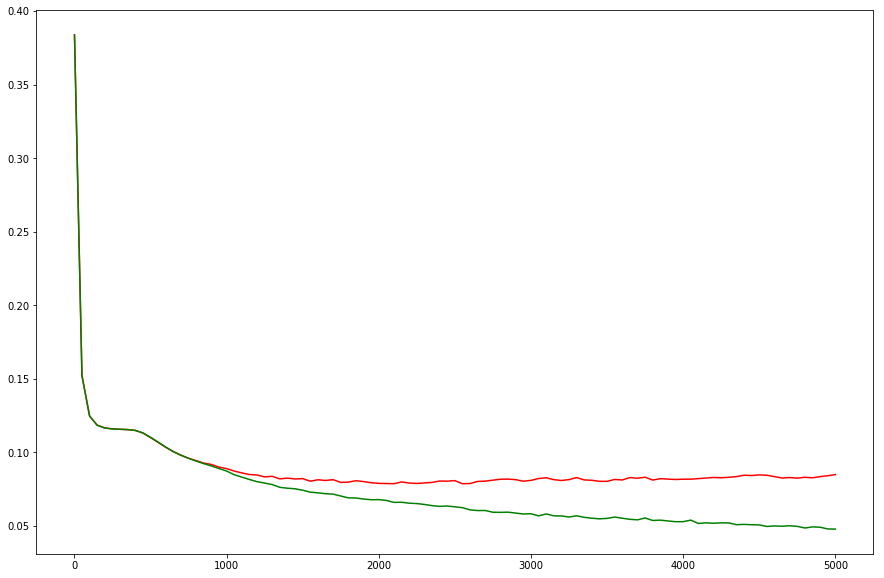

In [73]:
plt.figure(figsize=(15,10))
plt.plot(ep, vl_loss, color='red')
plt.plot(ep, tr_loss, color='green')
plt.show()

In [74]:
torch.cuda.memory_allocated(device=None)

148837376

### Output for submission

In [0]:
x_test_array = np.array(test_df[features_columns])
x_test_array = x_test_array.astype('float16')

for i in range(len(x_test_array)):
    x_test_array[i]=np.nan_to_num(x_test_array[i])

In [0]:
x_test = Variable(torch.from_numpy(x_test_array))

test_predictions = test_df[['TransactionID',TARGET]]
predictions = model(x_test.float())
test_predictions['prediction']  = predictions.detach().numpy()


## OUTPUT

if not LOCAL_TEST:
    test_predictions['isFraud'] = test_predictions['prediction']
    test_predictions[['TransactionID','isFraud']].to_csv('submission.csv', index=False)

### THE END

folds = StratifiedKFold(n_splits=3, shuffle=True, random_state=SEED)

#    X,y = tr_df[features_columns], tr_df[target]    
#    P,P_y = tt_df[features_columns], tt_df[target]  

#    tt_df = tt_df[['TransactionID',target]]    
#    predictions = np.zeros(len(tt_df))
    
for fold_, (trn_idx, val_idx) in enumerate(folds.split(x_train_array, y_train_array)):
    print('Fold:',fold_)
    # Subset data
    tr_x, tr_y = x_train_array[trn_idx,:], y_train_array[trn_idx]
    vl_x, vl_y = x_train_array[val_idx,:], y_train_array[val_idx]
    
    # Wrap in variable
    x_train = Variable(torch.from_numpy(tr_x))
    y_train = Variable(torch.from_numpy(tr_y))
    x_val = Variable(torch.from_numpy(vl_x))
    y_val = Variable(torch.from_numpy(vl_y))

    del tr_x, tr_y, vl_x, vl_y
    
    # Initiate our model
    model = Model()

    # Construct our loss function and an Optimizer. The call to model.parameters()
    # in the SGD constructor will contain the learnable parameters of the two
    # nn.Linear modules which are members of the model.
    criterion = torch.nn.BCELoss(size_average=True)

    #lnr_list = [0.1, 0.05]
    #for lnr in lnr_list:
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
    #print('learning rate = ', lnr)
    
    # Training loop on training set
    print('Start training on Fold ', fold_)
    for epoch in range(5):
        # Forward pass: Compute predicted y by passing x to the model
        y_train_pred = model(x_train.float())

        # Compute and print loss
        loss = criterion(y_train_pred, y_train.float())
        print(epoch, loss.item())#.data[0])

        # Zero gradients, perform a backward pass, and update the weights.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    # Test on validation set
    y_val_pred = model(x_val.float())
    loss = criterion(y_val_pred, y_val.float())
    print('Validation Score ', loss.item())

Output Prediction

x_test_array = np.array(test_df[features_columns])
x_test_array = x_test_array.astype('float16')

for i in range(len(x_test_array)):
    x_test_array[i]=np.nan_to_num(x_test_array[i])
    

#del test_df

x_test = Variable(torch.from_numpy(x_test_array))

test_predictions = test_df[['TransactionID',TARGET]]
predictions = model(x_test.float())
test_predictions['prediction']  = predictions.detach().numpy()


## OUTPUT

if not LOCAL_TEST:
    test_predictions['isFraud'] = test_predictions['prediction']
    test_predictions[['TransactionID','isFraud']].to_csv('submission.csv', index=False)

In [0]:
#x_train_array = np.array(train_df[features_columns])
#y_train_array = np.array(train_df[TARGET])#.values

#x_train_array = x_train_array.astype('float16')
#y_train_array = y_train_array.astype('float16')

#print(x_train_array.shape)
#print(y_train_array.shape)

In [0]:
#from skorch import NeuralNetClassifier

#net = NeuralNetClassifier(Model, max_epochs = 10, lr = 0.1, iterator_train_shuffle = True)

#net.fit(x_train, y_train)
#y_proba = net.predict_proba(x_train)

In [0]:
# our model
#model = Model()


# Construct our loss function and an Optimizer. The call to model.parameters()
# in the SGD constructor will contain the learnable parameters of the two
# nn.Linear modules which are members of the model.
#criterion = torch.nn.BCELoss(size_average=True)

#lnr_list = [0.1, 0.05]
#for lnr in lnr_list:
 #   optimizer = torch.optim.SGD(model.parameters(), lr=lnr)
 #   print('learning rate = ', lnr)
    
    # Training loop
  #  for epoch in range(5):
        # Forward pass: Compute predicted y by passing x to the model
  #      y_pred = model(x_train.float())

        # Compute and print loss
  #      loss = criterion(y_pred, y_train.float())
  #      print(epoch, loss.item())#.data[0])

        # Zero gradients, perform a backward pass, and update the weights.
   #     optimizer.zero_grad()
   #     loss.backward()
    #    optimizer.step()

In [0]:
# ========== Model params
lgb_params = {
                    'objective':'binary',
                    'boosting_type':'gbdt',
                    'metric':'auc',
                    'n_jobs':-1,
                    'learning_rate':0.01,
                    'num_leaves': 2**8,
                    'max_depth':-1,
                    'tree_learner':'serial',
                    'colsample_bytree': 0.7,
                    'subsample_freq':1,
                    'subsample':0.7,
                    'n_estimators':800,
                    'max_bin':255,
                    'verbose':-1,
                    'seed': SEED,
                    'early_stopping_rounds':100, 
                } 

In [0]:
########################### Model
import lightgbm as lgb

def make_predictions(tr_df, tt_df, features_columns, target, lgb_params, NFOLDS):
    folds = KFold(n_splits=NFOLDS, shuffle=True, random_state=SEED)

    X,y = tr_df[features_columns], tr_df[target]    
    P,P_y = tt_df[features_columns], tt_df[target]  

    tt_df = tt_df[['TransactionID',target]]    
    predictions = np.zeros(len(tt_df))
    
    for fold_, (trn_idx, val_idx) in enumerate(folds.split(X, y)):
        print('Fold:',fold_)
        tr_x, tr_y = X.iloc[trn_idx,:], y[trn_idx]
        vl_x, vl_y = X.iloc[val_idx,:], y[val_idx]
            
        print(len(tr_x),len(vl_x))
        tr_data = lgb.Dataset(tr_x, label=tr_y)

        if LOCAL_TEST:
            vl_data = lgb.Dataset(P, label=P_y) 
        else:
            vl_data = lgb.Dataset(vl_x, label=vl_y)  

        estimator = lgb.train(
            lgb_params,
            tr_data,
            valid_sets = [tr_data, vl_data],
            verbose_eval = 200,
        )   
        
        pp_p = estimator.predict(P)
        predictions += pp_p/NFOLDS

        if LOCAL_TEST:
            feature_imp = pd.DataFrame(sorted(zip(estimator.feature_importance(),X.columns)), columns=['Value','Feature'])
            print(feature_imp)
        
        del tr_x, tr_y, vl_x, vl_y, tr_data, vl_data
        gc.collect()
        
    tt_df['prediction']  = predictions
    
    return tt_df
## -------------------

In [0]:
########################### Model Train

#if LOCAL_TEST:
#    test_predictions = make_predictions(train_df, test_df, features_columns, TARGET, lgb_params)
#    print(metrics.roc_auc_score(test_predictions[TARGET], test_predictions['prediction']))
#else:
#    lgb_params['learning_rate'] = 0.01
#    lgb_params['n_estimators'] = 800
#    lgb_params['early_stopping_rounds'] = 100    
#    test_predictions = make_predictions(train_df, test_df, features_columns, TARGET, lgb_params, 10)

In [0]:
## OUTPUT

#if not LOCAL_TEST:
#    test_predictions['isFraud'] = test_predictions['prediction']
#    test_predictions[['TransactionID','isFraud']].to_csv('submission.csv', index=False)

In [0]:
#target_encoding_list = ['ProductCD', 'card4', 'card6', 'M4', 'P_emaildomain', 'R_emaildomain']#, 'DeviceType']

#for col in target_encoding_list:
#    targetc = KFoldTargetEncoderTrain(col,'isFraud',n_fold=10)
 #   train_df = targetc.fit_transform(train_df)

  #  test_targetc = KFoldTargetEncoderTest(train_df,col,col+'_Kfold_Target_Enc')
   # test_targetc.fit_transform(test_df)

In [0]:
########################### card4, card6, ProductCD
#################################################################################
# Converting Strings to ints(or floats if nan in column) using frequency encoding
# We will be able to use these columns as category or as numerical feature

#for col in ['card4', 'card6', 'ProductCD']:
 #   print('Encoding', col)
 #   temp_df = pd.concat([train_df[[col]], test_df[[col]]])
 #   col_encoded = temp_df[col].value_counts().to_dict()   
 #   train_df[col] = train_df[col].map(col_encoded)
 #   test_df[col]  = test_df[col].map(col_encoded)
 #   print(col_encoded)

In [0]:
########################### M columns
#################################################################################
# Converting Strings to ints(or floats if nan in column)

#for col in ['M1','M2','M3','M5','M6','M7','M8','M9']:
#    train_df[col] = train_df[col].map({'T':1, 'F':0})
#    test_df[col]  = test_df[col].map({'T':1, 'F':0})

#for col in ['M4']:
 #   print('Encoding', col)
 #   temp_df = pd.concat([train_df[[col]], test_df[[col]]])
 #   col_encoded = temp_df[col].value_counts().to_dict()   
 #   train_df[col] = train_df[col].map(col_encoded)
 #   test_df[col]  = test_df[col].map(col_encoded)
 #   print(col_encoded)

In [0]:
########################### Final Minification
#################################################################################

#train_df = reduce_mem_usage(train_df)
#test_df  = reduce_mem_usage(test_df)

#train_identity = reduce_mem_usage(train_identity)
#test_identity  = reduce_mem_usage(test_identity)

In [0]:
########################### Export
#################################################################################

#train_df.to_pickle('train_transaction.pkl')
#test_df.to_pickle('test_transaction.pkl')

#train_identity.to_pickle('train_identity.pkl')
#test_identity.to_pickle('test_identity.pkl')

In [0]:
#SEED = 42
#seed_everything(SEED)
#LOCAL_TEST = False
#TARGET = 'isFraud'

In [0]:
########################### Reset values for "noise" card1
#valid_card = train_df['card1'].value_counts()
#valid_card = valid_card[valid_card>10]
#valid_card = list(valid_card.index)
    
#train_df['card1'] = np.where(train_df['card1'].isin(valid_card), train_df['card1'], np.nan)
#test_df['card1']  = np.where(test_df['card1'].isin(valid_card), test_df['card1'], np.nan)

In [0]:
## FREQUENCY ENCODING
#i_cols = ['card1','card2','card3','card5',
#          'C1','C2','C3','C4','C5','C6','C7','C8','C9','C10','C11','C12','C13','C14',
#          'D1','D2','D3','D4','D5','D6','D7','D8','D9',
#          'addr1','addr2',
#          'dist1','dist2',
#          'P_emaildomain', 'R_emaildomain'
#         ]

#for col in i_cols:
#    temp_df = pd.concat([train_df[[col]], test_df[[col]]])
#    fq_encode = temp_df[col].value_counts().to_dict()   
#    train_df[col+'_fq_enc'] = train_df[col].map(fq_encode)
#    test_df[col+'_fq_enc']  = test_df[col].map(fq_encode)

In [0]:
## ProductCD and M4 Target mean
#for col in ['ProductCD','M4']:
#    temp_dict = train_df.groupby([col])[TARGET].agg(['mean']).reset_index().rename(
                                                  #      columns={'mean': col+'_target_mean'})
#    temp_dict.index = temp_dict[col].values
#    temp_dict = temp_dict[col+'_target_mean'].to_dict()

#    train_df[col+'_target_mean'] = train_df[col].map(temp_dict)
#    test_df[col+'_target_mean']  = test_df[col].map(temp_dict)

In [0]:
## Encode Str columns
#for col in list(train_df):
#    if train_df[col].dtype=='O':
#        print(col)
#        train_df[col] = train_df[col].fillna('unseen_before_label')
#        test_df[col]  = test_df[col].fillna('unseen_before_label')
        
#        train_df[col] = train_df[col].astype(str)
#        test_df[col] = test_df[col].astype(str)
        
#        le = LabelEncoder()
#        le.fit(list(train_df[col])+list(test_df[col]))
#        train_df[col] = le.transform(train_df[col])
#        test_df[col]  = le.transform(test_df[col])
        
#        train_df[col] = train_df[col].astype('category')
#        test_df[col] = test_df[col].astype('category')